In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt

In [2]:
input_data = pd.read_csv('STORAGE_data/es-1min_FULL.csv')
input_data.index = pd.to_datetime(input_data.date + ' ' + input_data.time)
input_data

,date,time,open,high,low,close
2011-12-19 09:30:00,12/19/2011,9:30:00,1215.875,1216.375,1215.625,1215.875
2011-12-19 09:31:00,12/19/2011,9:31:00,1215.875,1217.125,1215.875,1217.125
2011-12-19 09:32:00,12/19/2011,9:32:00,1217.125,1217.875,1217.125,1217.625
2011-12-19 09:33:00,12/19/2011,9:33:00,1217.625,1218.375,1217.625,1218.125
2011-12-19 09:34:00,12/19/2011,9:34:00,1218.125,1218.375,1217.625,1217.875
...,...,...,...,...,...,...
2015-12-16 16:10:00,12/16/2015,16:10:00,2070.125,2070.375,2069.875,2070.125
2015-12-16 16:11:00,12/16/2015,16:11:00,2070.125,2070.875,2069.125,2069.250
2015-12-16 16:12:00,12/16/2015,16:12:00,2069.250,2072.125,2069.125,2072.125
2015-12-16 16:13:00,12/16/2015,16:13:00,2072.125,2072.625,2071.625,2072.000


In [3]:
data = input_data.drop(['date', 'time'], axis=1)

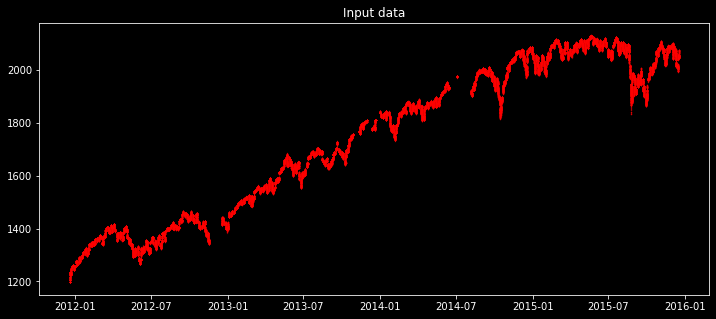

In [4]:
plt.style.use('dark_background')
plt.figure(figsize=(12,5))
plt.plot(data.close, 'o', markersize=.3, color='red', alpha=.6)
plt.title('Input data')
plt.show()

In [7]:
def _start_duplicates_removing(inp_data):
    ret_data = inp_data.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
    assert len(ret_data.index) == len(ret_data.index.unique())
    print(f'Duplicates at {1 - (ret_data.shape[0] / inp_data.shape[0]):.2%} of data')
    return ret_data

    pass
def normalize_data(inp_data: pd.DataFrame, show=True):
    #   Calculate the right numbers of observations intra day
    NORMAL_MINUTES = (15 - 9) * 60 + 59 - 29
    #   Checks for duplicates
    if show:
        plt.style.use('dark_background')
        plt.figure(figsize=(12,8))
        plt.subplot(2,1,1)
        plt.plot(inp_data.close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Input data')

    if len(inp_data.index) != len(inp_data.index.unique()):
        inp_data = _start_duplicates_removing(inp_data)
    #   In data not of all information about trade-day. For example at date 2011-12-19 data ends at 15:59. At date 2015-12-19 data ends at 16:14. Notice that normal trade day ends at 16:30.
    #   At start lets drop lines with days with zero observations.
    mask = ~np.in1d(inp_data.index.date,inp_data.resample('1D').count().query(f'open < {NORMAL_MINUTES}').index.date)

    if show:
        plt.subplot(2,1,2)
        plt.plot(inp_data.loc[mask,:].close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Cut data')
        plt.show()
    return inp_data

#preprocessed_data = normalize_data(data)

[2, 7, 20, 54, 148, 403, 1096, 2980, 8103, 22026, 59874]
574706.0322449106


-756.6535843278673

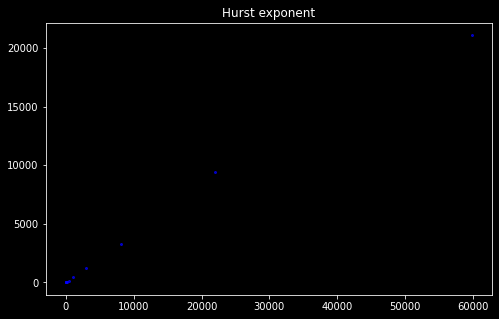

In [255]:
def _hurst_est(inp_data: pd.DataFrame, show=True, HYPERPARAMETER_0:int=0, ANIS_LOYD_CORRECTION=False):
    """
    HYPERPARAMETER_0 can increase the array of q lags. Default = 0. Must be int
    :param inp_data:
    :return:
    """
    if show:
        plt.style.use('dark_background')
        plt.figure(figsize=(8,5))
        plt.title('Hurst exponent')
    inp_data = inp_data.close.values
    NULL = 1
    q_value = [int(np.exp(_)) for _ in range(1, int(np.log(len(inp_data)) / NULL) + HYPERPARAMETER_0)]
    print(q_value)
    if q_value[-1] > len(inp_data):
        raise ValueError('Time-lag value is bigger than input data')

    rs_array = list()
    for buffer_data_size in q_value:
        buffer_data = inp_data[:buffer_data_size]
        mean_buffer = np.mean(buffer_data)
        cumulative_deviate = np.cumsum(np.subtract(buffer_data, mean_buffer))
        hurst_range = max(cumulative_deviate) - min(cumulative_deviate)
        standard_deviation = np.std(buffer_data, ddof=0)
        rs_array.append(hurst_range/standard_deviation)
        if show:
            plt.plot(buffer_data_size, rs_array[-1], 'o', color='blue', markersize=2, alpha=.7)

    if ANIS_LOYD_CORRECTION == False:
        print(rs_array)
        print(q_value)
        print(np.polyfit(q_value, rs_array, deg=1))
    if ANIS_LOYD_CORRECTION == True:
        if len(inp_data) > 340:
            ALC = (1 / np.sqrt(len(inp_data) * np.pi / 2)) * np.sum(np.sqrt([(len(inp_data) - i) / i for i in range(1, len(inp_data) - 1)]))
            print(np.sum(np.sqrt([(len(inp_data) - i) / i for i in range(1, len(inp_data) - 1)])))
            return 0.5 + np.polyfit(q_value, rs_array, deg=1)[0] - ALC

_hurst_est(preprocessed_data, ANIS_LOYD_CORRECTION=True)

In [207]:
len(preprocessed_data)

366432

In [225]:
np.cumsum(np.subtract(np.array([1,2,3,45]),1))

array([ 0,  1,  3, 47])

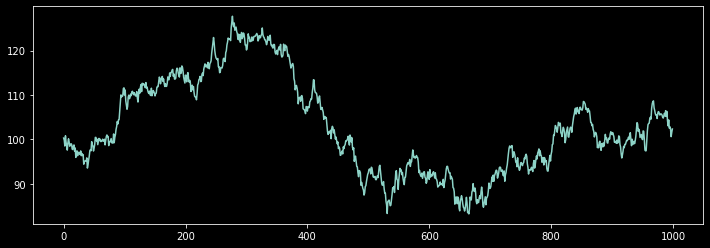

[2, 4, 8, 16, 32, 64, 128, 256]
[-0.16379163090214321, 0.3159957837548064, 0.7430016377175162, 1.2330664647836895, 2.390635782115166, 3.099476738585485, 3.852606337592704, 4.5740250898919985]
[2, 4, 8, 16, 32, 64, 128, 256]
1.0146055915666918


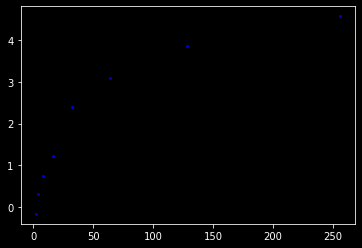

In [107]:
ANIS_LOYD_CORRECTION = True
show=True
np.random.seed(124)
sample_size = 1000
scalar = 100
NULL = 1
inp_data = (np.cumsum(np.random.randn(sample_size)) + scalar)
plt.figure(figsize=(12,4))
plt.plot(inp_data)
plt.show()
q_value = [2 ** _ for _ in range(1, int(np.log2(len(inp_data)) / NULL) + 0)]
print(q_value)
if q_value[-1] > len(inp_data):
    raise ValueError('Time-lag value is bigger than input data')

rs_array = list()
ALC = (((q_value[-1] - .5) / q_value[-1]) / np.sqrt(q_value[-1] * np.pi / 2)) * np.sum([np.sqrt((q_value[-1] - i) / i) for i in range(1, q_value[-1] - 1)])
for buffer_data_size in q_value:
    buffer_data = inp_data[:buffer_data_size]
    mean_buffer = np.mean(buffer_data)
    cumulative_deviate = np.cumsum(np.subtract(buffer_data, mean_buffer))
    hurst_range = max(cumulative_deviate) - min(cumulative_deviate)
    standard_deviation = np.std(buffer_data, ddof=0)
    if ANIS_LOYD_CORRECTION == True:
        if len(inp_data) > 340:
            rs_array.append(np.log(hurst_range/standard_deviation) - np.log(ALC) + np.log(q_value[-1])/2)
    if ANIS_LOYD_CORRECTION == False:
        rs_array.append(hurst_range/standard_deviation)
    if show:
        plt.plot(buffer_data_size, rs_array[-1], 'o', color='blue', markersize=2, alpha=.7)
print(rs_array)
print(q_value)
print(np.polyfit(np.log(q_value), rs_array, deg=1)[0])

In [101]:
from tqdm.notebook import tqdm
np.random.seed(124)
sample_size = 100000
scalar = 100
def _hurst_estimate_time_lag(time_lag, inp_data):
    number_of_sub_series = len(inp_data) // time_lag
    R_array = list()
    S_array = list()
    for sub_serial in range(0, number_of_sub_series):
        buffer_data = inp_data[sub_serial * time_lag:(sub_serial + 1) * time_lag]
        if len(buffer_data) == 0:
            break
        buffer_mean = np.nanmean(buffer_data)
        normalized = buffer_data - buffer_mean
        cumulative_normalized = np.cumsum(normalized)
        standard_deviation = np.nanstd(buffer_data, ddof=0)
        R_array.append(max(cumulative_normalized) - min(cumulative_normalized))
        S_array.append(standard_deviation)
    mean_RS = np.nanmean(np.divide(R_array, S_array))
    return mean_RS

def _hurst_runner(inp_data, HYPERPARAM_0, ANIS_LLOYD):

    Q_ARRAY = [2 ** q for q in range(1, int(np.log2(len(inp_data)) / HYPERPARAM_0))]
    #print(Q_ARRAY)
    #M = len(inp_data) / 2
    #Q_ARRAY = [q for q in range(5, int(M / HYPERPARAM_0), int(M / HYPERPARAM_0) // 10)]
    #Q_ARRAY = [2 ** q for q in range(1, int(np.log(len(inp_data))))]

    RS_ARRAY = list()
    for _ in Q_ARRAY:
        RS_ARRAY.append(_hurst_estimate_time_lag(_, inp_data))
    def result(_buf_x_, COFFS):
        return np.multiply(_buf_x_, COFFS[0]) + COFFS[1]
    # print('Q ARRAY \n', np.log(Q_ARRAY))
    # print('RS ARRAY: \n', np.log(RS_ARRAY))
    # print(len(Q_ARRAY), '<- Q ARRAY; RS_ARRAY -> ', len(RS_ARRAY))
    Q_ARRAY = Q_ARRAY[1:]
    RS_ARRAY = RS_ARRAY[1:]
    if not ANIS_LLOYD:
        POLYFIT = np.polyfit(np.log(Q_ARRAY), np.log(RS_ARRAY), deg=1)
    if ANIS_LLOYD:
        if Q_ARRAY[-1] <= 340:
            ALC = np.sum([np.sqrt((Q_ARRAY[-1] - i) / i) for i in range(1, Q_ARRAY[-1] -1)]) / np.sqrt(Q_ARRAY[-1] * np.pi / 2)
            POLYFIT = np.polyfit(np.log(Q_ARRAY), np.log(RS_ARRAY) - np.log(ALC) + np.log(Q_ARRAY[-1]) / 2, deg=1)
        if Q_ARRAY[-1] > 340:
            ALC = np.sum([np.sqrt((Q_ARRAY[-1] - i) / i) for i in range(1, Q_ARRAY[-1] -1)]) / np.sqrt(Q_ARRAY[-1] * np.pi / 2)
            POLYFIT = np.polyfit(np.log(Q_ARRAY), np.log(RS_ARRAY) - np.log(ALC) + np.log(Q_ARRAY[-1]) / 2, deg=1)
    # print(f'FOR sample_len={HYPERPARAM_0} MAX Q = {Q_ARRAY[-1]}\nn * {POLYFIT[0]} + {POLYFIT[1]}\n================')
    #print(f'FOR LAG Q={Q_ARRAY[-1]} HURST EXPONENT={POLYFIT[0]}')
    return POLYFIT[0], POLYFIT[1]

def hurst_optimizer(inp_data, ANIS_LLOYD=False, simplify=1):
    plt.figure(figsize=(12,6))
    plt.title('Hard')
    inp_data = np.log(inp_data)
    inp_data = np.diff(inp_data) / inp_data[:-1]
    #for HYPER in range(int(np.log(len(inp_data)) / 2), 1, -1):
    for HYPER in tqdm(np.arange(4,1.5,-0.2 * simplify)):
        CF_a, CF_b = _hurst_runner(inp_data, HYPERPARAM_0=HYPER, ANIS_LLOYD=ANIS_LLOYD)
        plt.plot((2 ** int(np.log2(len(inp_data)) / HYPER)), CF_a,  'o', color='blue', markersize=2, alpha=.7)

Duplicates at 6.18% of data


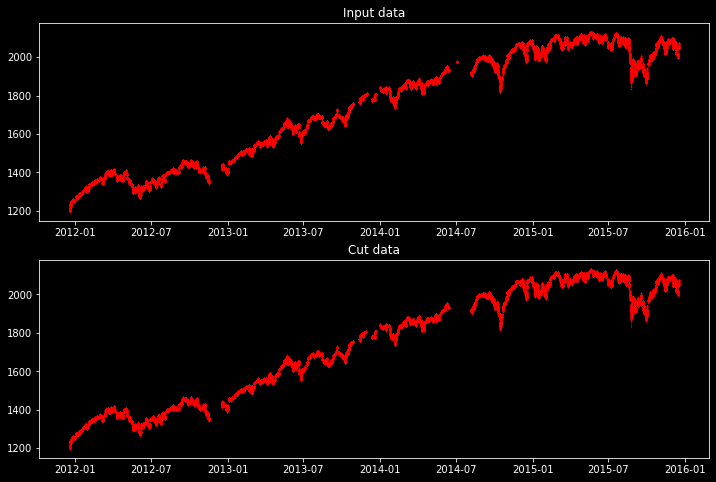

In [9]:
nrm = normalize_data(data).close.values

  0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_835/508253065.py:19: RuntimeWarning: invalid value encountered in true_divide
  mean_RS = np.nanmean(np.divide(R_array, S_array))


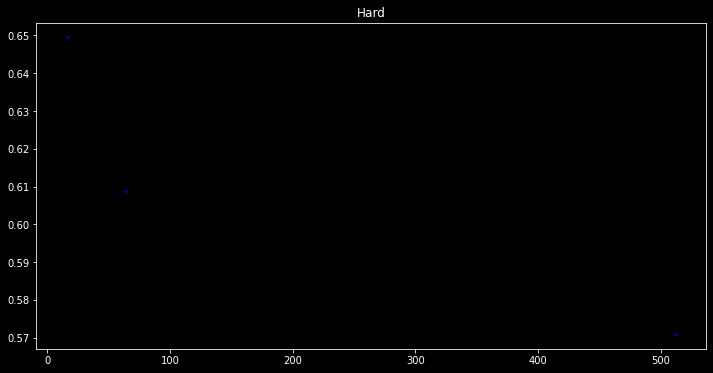

In [102]:
hurst_optimizer(nrm, simplify=5)

  0%|          | 0/183 [00:00<?, ?it/s]

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_835/4028269210.py:19: RuntimeWarning: invalid value encountered in true_divide
  mean_RS = np.nanmean(np.divide(R_array, S_array))


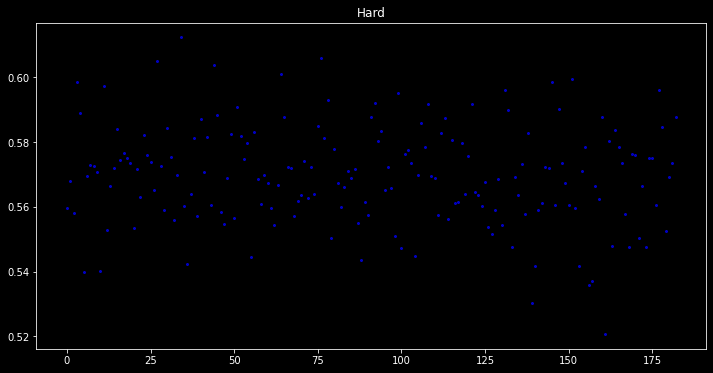

In [90]:
frame = 2000
plt.figure(figsize=(12,6))
plt.title('Hard')
#   VERSION A
for _ in tqdm(range(0, len(nrm) // frame)):
    #buf_data = nrm[_* frame: (_+1)* frame]
    buf_data = np.log(nrm[_* frame: (_+1)* frame])
    #buf_data = np.diff(buf_data) / buf_data[:-1]
    buf_data = np.diff(buf_data) / buf_data[:-1]
    plt.plot(_, _hurst_runner(buf_data, 1.2, ANIS_LLOYD=False)[0], 'o', color='blue', markersize=2, alpha=.7)

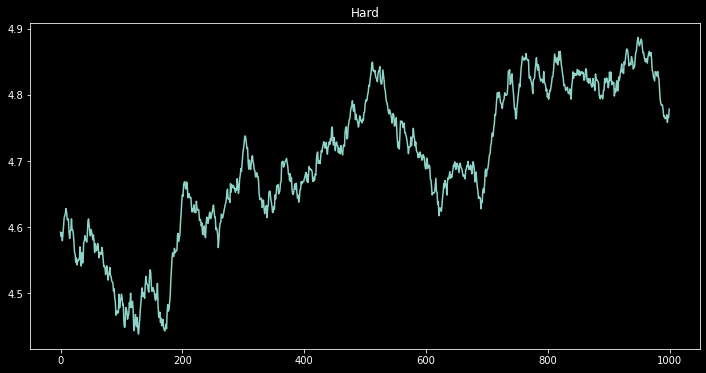

  0%|          | 0/80 [00:00<?, ?it/s]

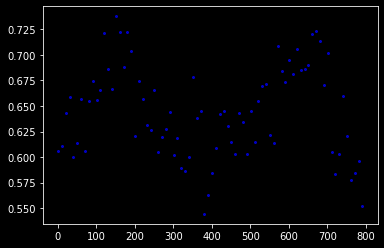

In [99]:
frame = 200
testing = np.log([np.exp(x) for x in np.linspace(-5, 5, 100_0)])
testing = np.log(np.random.randn(sample_size) + scalar)
testing = np.log(np.cumsum(np.random.randn(sample_size)) + scalar)
plt.figure(figsize=(12,6))
plt.title('Hard')
plt.plot(testing)
plt.show()
for _ in tqdm(range(1, len(testing) - frame, 10)):
    buf_data = testing[_: _ + frame]
    buf_data = np.diff(buf_data) / buf_data[:-1]
    plt.plot(_, _hurst_runner(buf_data, 1, ANIS_LLOYD=False)[0], 'o', color='blue', markersize=2, alpha=.7)

  0%|          | 0/2430 [00:00<?, ?it/s]

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_835/4028269210.py:19: RuntimeWarning: invalid value encountered in true_divide
  mean_RS = np.nanmean(np.divide(R_array, S_array))


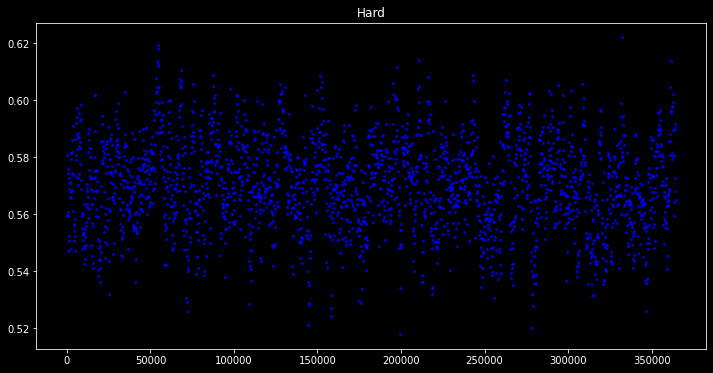

In [39]:
plt.figure(figsize=(12,6))
plt.title('Hard')
#   VERSION B
for _ in tqdm(range(1, len(nrm) - frame, 150)):
    buf_data = nrm[_: _ + frame]
    buf_data = np.diff(buf_data) / buf_data[:-1]
    plt.plot(_, _hurst_runner(buf_data, 1.2, ANIS_LLOYD=False)[0], 'o', color='blue', markersize=2, alpha=.7)

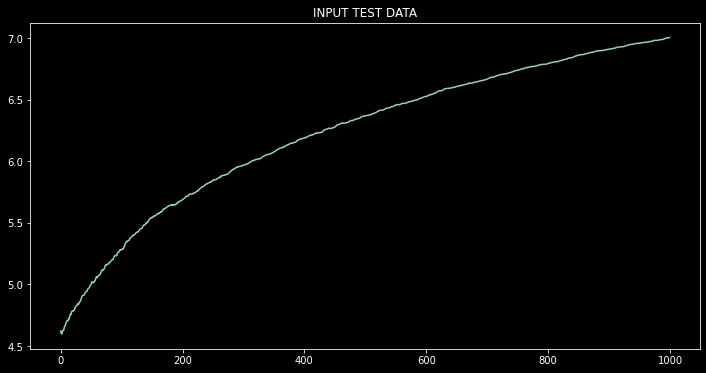

  0%|          | 0/6 [00:00<?, ?it/s]

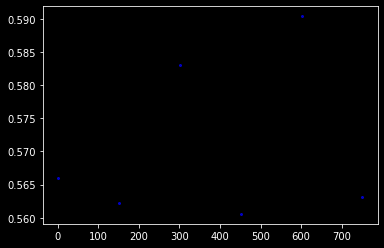

In [91]:
sample_size = 1000
scalar = 100
frame = 200
testing = np.log(np.cumsum(np.random.randn(sample_size) + 1) + scalar)
plt.figure(figsize=(12,6))
plt.title('INPUT TEST DATA')
plt.plot(testing)
plt.show()
#   VERSION B
for _ in tqdm(range(1, len(testing) - frame, 150)):
    buf_data = testing[_: _ + frame]
    buf_data = np.diff(buf_data) / buf_data[:-1]
    plt.plot(_, _hurst_runner(buf_data, 1, ANIS_LLOYD=False)[0], 'o', color='blue', markersize=2, alpha=.7)

In [76]:
_hurst_runner(np.diff(testing), 1, False)

(0.5840280865836709, -0.26137318499082324)

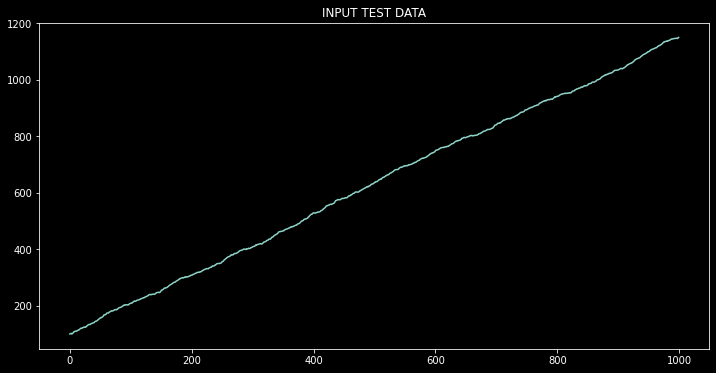

  0%|          | 0/20 [00:00<?, ?it/s]

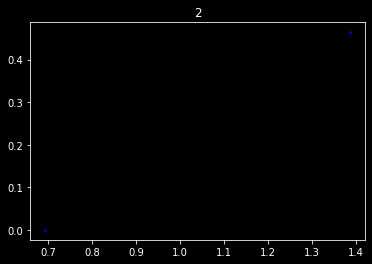

FOR LAG Q=4 HURST EXPONENT=0.1674215188776868
FOR LAG Q=4 HURST EXPONENT=0.19726736775063686
FOR LAG Q=4 HURST EXPONENT=0.18724594014411983
FOR LAG Q=4 HURST EXPONENT=0.18294890906231515
FOR LAG Q=4 HURST EXPONENT=0.18674653873119726
FOR LAG Q=4 HURST EXPONENT=0.19123843849433445
FOR LAG Q=4 HURST EXPONENT=0.17494205072520733
FOR LAG Q=4 HURST EXPONENT=0.16818172062983988
FOR LAG Q=4 HURST EXPONENT=0.19733619201869892
FOR LAG Q=4 HURST EXPONENT=0.19609734965236708
FOR LAG Q=4 HURST EXPONENT=0.18677963648262486
FOR LAG Q=4 HURST EXPONENT=0.173832100896953
FOR LAG Q=4 HURST EXPONENT=0.15526735066506486
FOR LAG Q=4 HURST EXPONENT=0.18880218267468535
FOR LAG Q=4 HURST EXPONENT=0.18146897612641416
FOR LAG Q=4 HURST EXPONENT=0.1957110963666633
FOR LAG Q=4 HURST EXPONENT=0.18477552643224887
FOR LAG Q=4 HURST EXPONENT=0.1861117469231551
FOR LAG Q=4 HURST EXPONENT=0.1602554064516924
FOR LAG Q=4 HURST EXPONENT=0.1628656774305628


/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_4038/3156582331.py:13: RankWarning: Polyfit may be poorly conditioned
  plt.plot(_, _hurst_runner(buf_data, 2, ANIS_LLOYD=False)[0], 'o', color='blue', markersize=2, alpha=.7)
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_4038/3156582331.py:13: RankWarning: Polyfit may be poorly conditioned
  plt.plot(_, _hurst_runner(buf_data, 2, ANIS_LLOYD=False)[0], 'o', color='blue', markersize=2, alpha=.7)
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_4038/3156582331.py:13: RankWarning: Polyfit may be poorly conditioned
  plt.plot(_, _hurst_runner(buf_data, 2, ANIS_LLOYD=False)[0], 'o', color='blue', markersize=2, alpha=.7)
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_4038/3156582331.py:13: RankWarning: Polyfit may be poorly conditioned
  plt.plot(_, _hurst_runner(buf_data, 2, ANIS_LLOYD=False)[0], 'o', color='blue', markersize=2, alpha=.7)
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_4

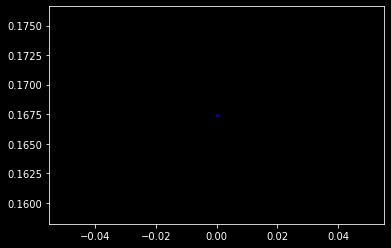

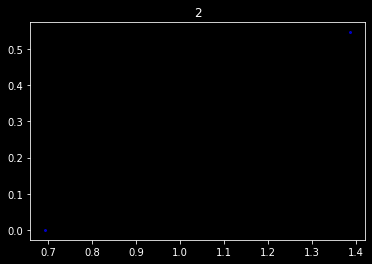

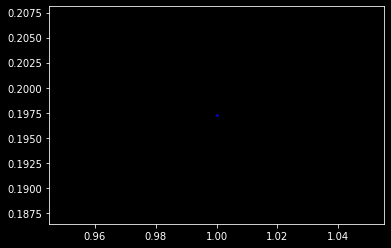

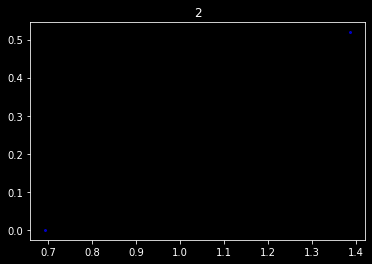

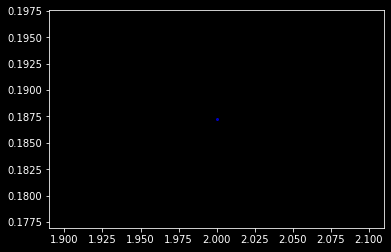

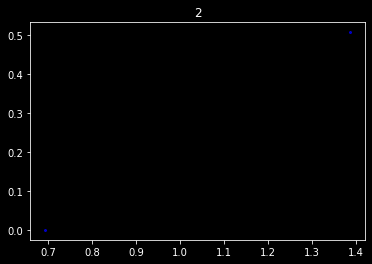

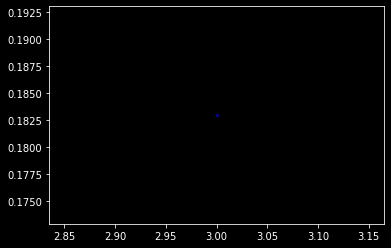

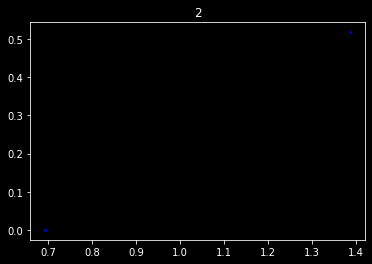

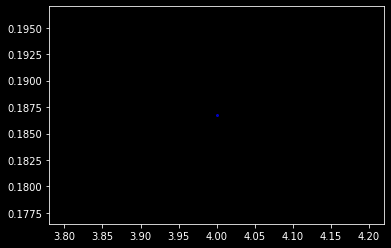

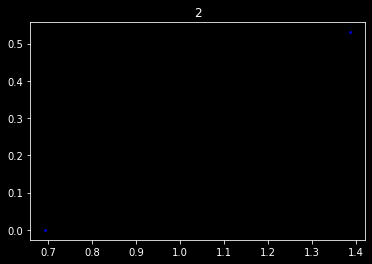

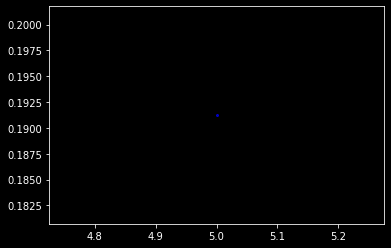

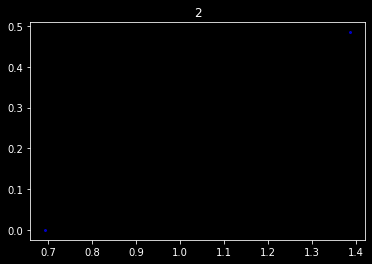

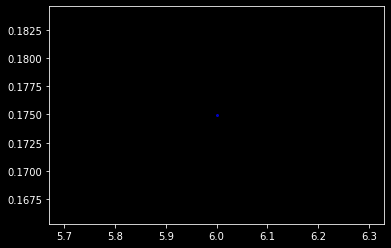

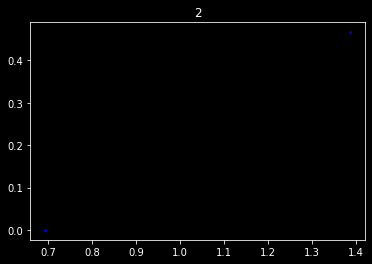

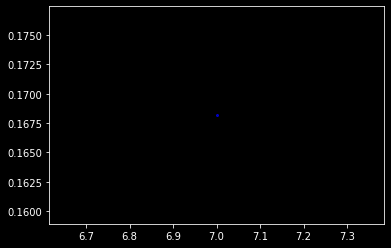

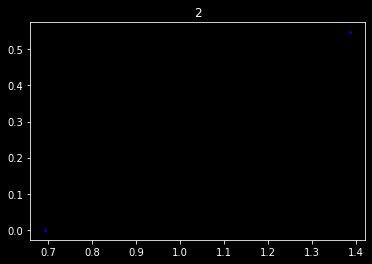

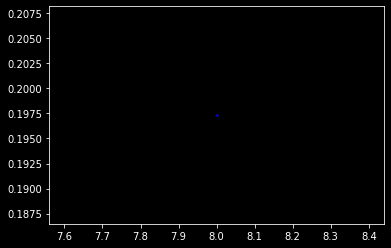

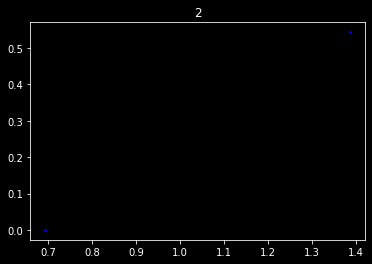

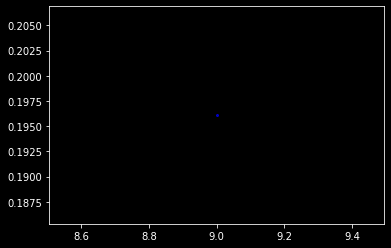

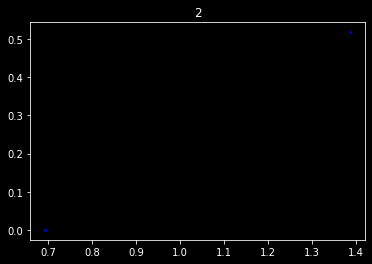

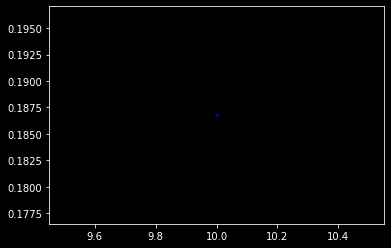

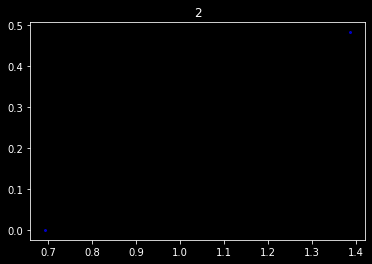

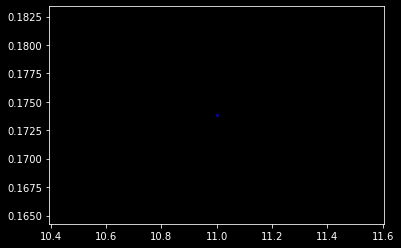

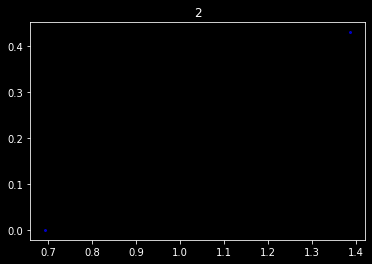

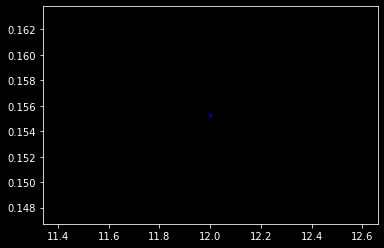

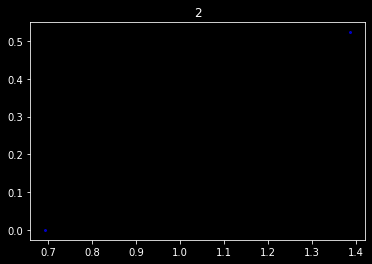

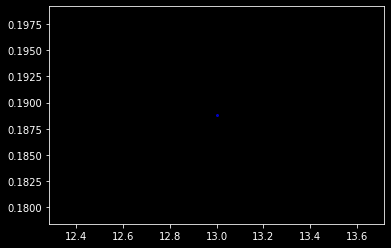

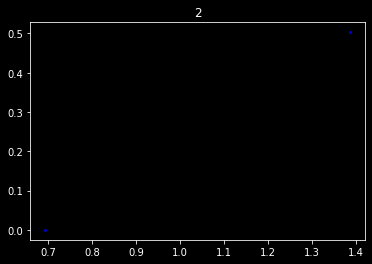

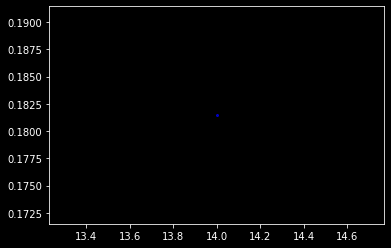

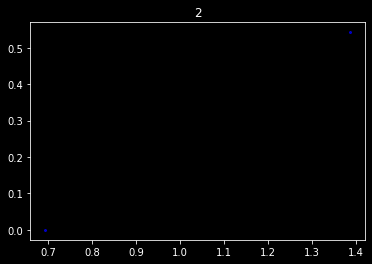

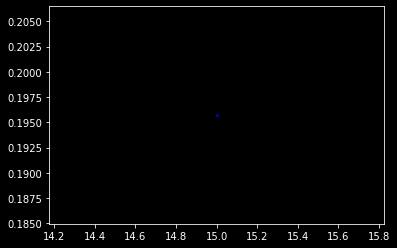

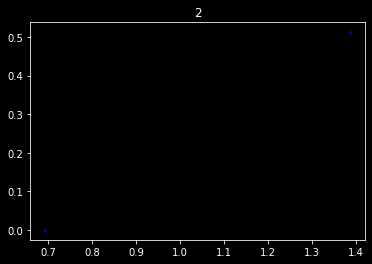

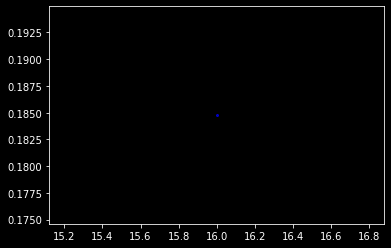

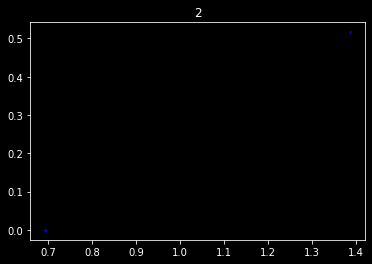

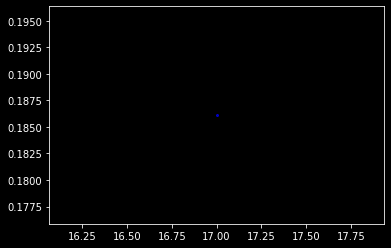

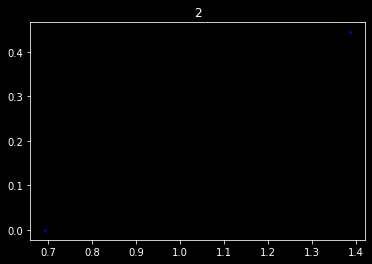

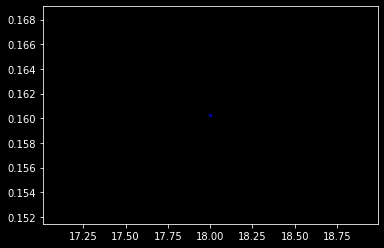

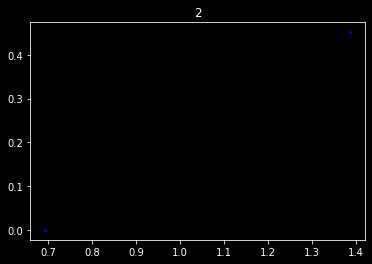

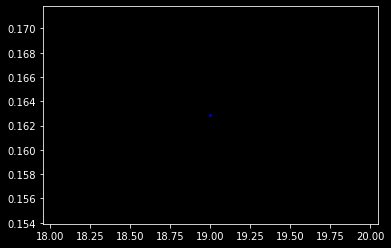

In [152]:
sample_size = 1000
scalar = 100
frame = 50
testing = np.cumsum(np.random.randn(sample_size) + 1) + scalar
plt.figure(figsize=(12,6))
plt.title('INPUT TEST DATA')
plt.plot(testing)
plt.show()
#   VERSION A
for _ in tqdm(range(0, len(testing) // frame)):
    buf_data = testing[_* frame: (_+1)* frame]
    buf_data = np.diff(buf_data) / buf_data[:-1]
    plt.plot(_, _hurst_runner(buf_data, 2, ANIS_LLOYD=False)[0], 'o', color='blue', markersize=2, alpha=.7)

  0%|          | 0/9 [00:00<?, ?it/s]

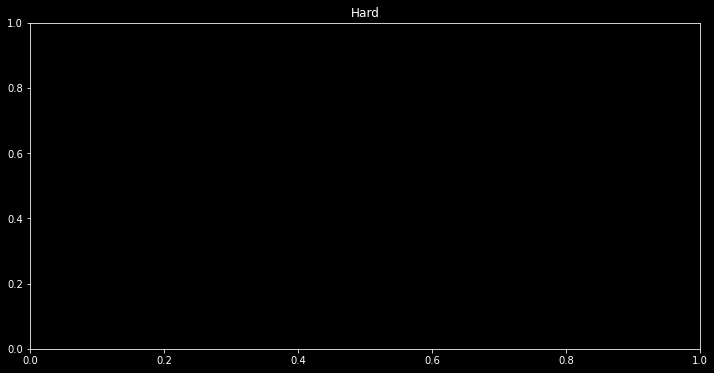

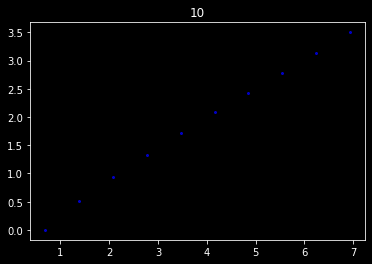

FOR LAG Q=1024 HURST EXPONENT=0.5328128656908833
FOR LAG Q=1024 HURST EXPONENT=0.5328128656908833
FOR LAG Q=1024 HURST EXPONENT=0.5328128656908833
FOR LAG Q=1024 HURST EXPONENT=0.5328128656908833
FOR LAG Q=1024 HURST EXPONENT=0.5328128656908833


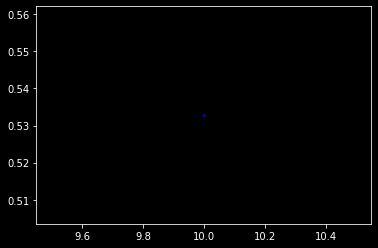

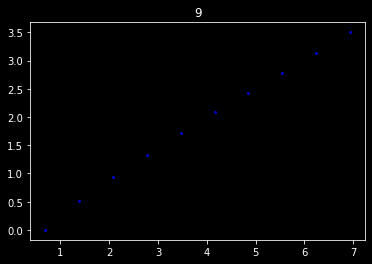

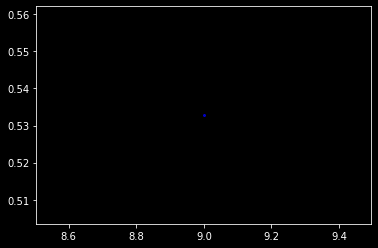

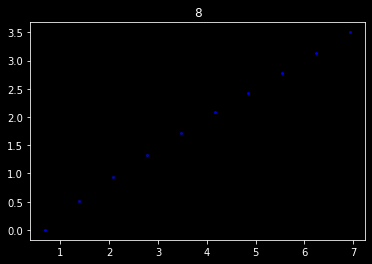

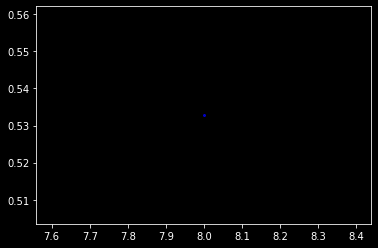

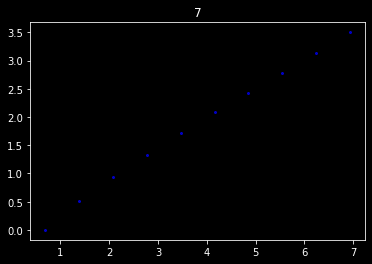

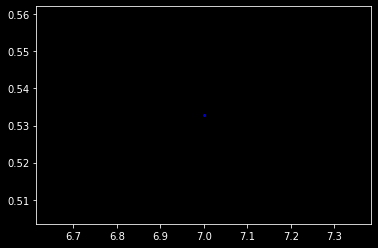

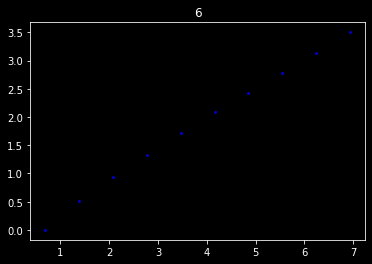

KeyboardInterrupt: 

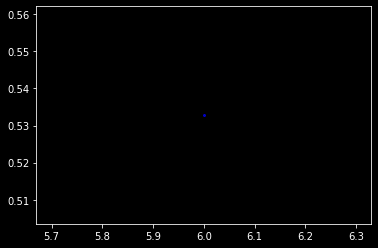

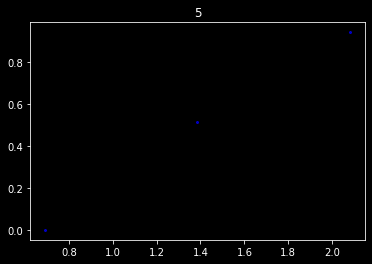

In [143]:
testing = np.cumsum(np.random.randn(sample_size) + 1) + scalar
testing = np.diff(testing) / testing[:-1]
hurst_optimizer(testing, ANIS_LLOYD=True)
hurst_optimizer(testing)

FOR LAG Q=299 HURST EXPONENT=0.7095857073414881


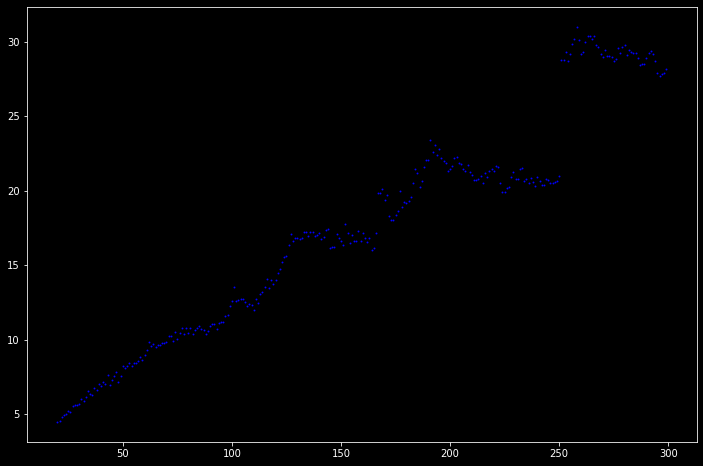

In [139]:
def _hurst_estimate_time_lag(time_lag, inp_data):
    number_of_sub_series = len(inp_data) // time_lag
    R_array = list()
    S_array = list()
    for sub_serial in range(0, number_of_sub_series):
        buffer_data = np.array(inp_data[sub_serial * time_lag:(sub_serial + 1) * time_lag])
        buffer_mean = sum(buffer_data) / len(buffer_data)
        normalized = buffer_data - buffer_mean
        cumulative_normalized = np.cumsum(normalized)
        standard_deviation = np.std(buffer_data, ddof=0)
        R_array.append(max(cumulative_normalized) - min(cumulative_normalized))
        S_array.append(standard_deviation)
    mean_RS = np.mean(np.divide(R_array, S_array))
    return mean_RS

def _hurst_runner(inp_data, ANIS_LLOYD=None):

    Q_ARRAY = [q for q in range(20, 300)]
    RS_ARRAY = list()
    for _ in Q_ARRAY:
        plt.plot(_, _hurst_estimate_time_lag(_, inp_data), 'o', color='blue', markersize=.9)
        RS_ARRAY.append(_hurst_estimate_time_lag(_, inp_data))
    POLYFIT = np.polyfit(np.log(Q_ARRAY), np.log(RS_ARRAY), deg=1)
    print(f'FOR LAG Q={Q_ARRAY[-1]} HURST EXPONENT={POLYFIT[0]}')
    return POLYFIT[0], POLYFIT[1]

sample_size = 1000
scalar = 100
frame = 500
testing = np.cumsum(np.random.randn(sample_size)) + scalar
testing = np.diff(testing) / testing[:-1]
plt.figure(figsize=(12,8))
for _ in range(0, sample_size // frame - 1):
    _hurst_runner(testing[_* frame: (_+1) * frame])[0]
    #plt.plot(_*frame, _hurst_runner(testing[_* frame: (_+1) * frame])[0], 'o', color='blue')

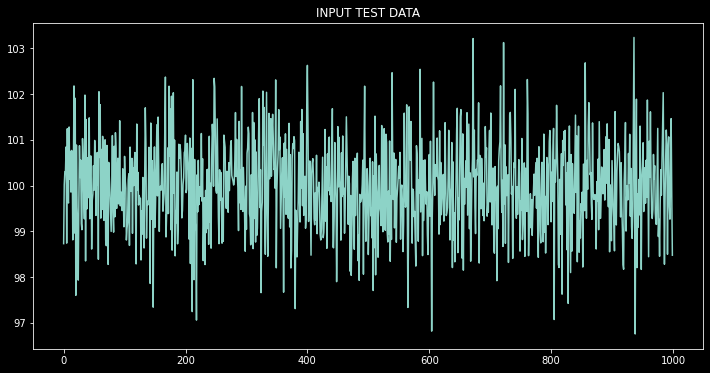

FOR LAG Q=499 HURST EXPONENT=0.5971926532694403


(0.5971926532694403, -0.37450232285207313)

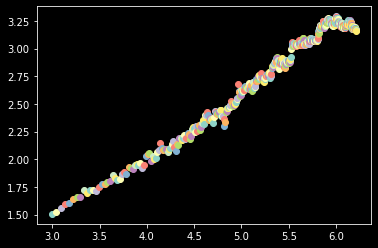

In [100]:
testing = np.random.randn(sample_size) + scalar
_hurst_runner(testing)